In [1]:
import config
from Preprocessing.meanProcessor import MeanProcessor
from Preprocessing.simpleProcessor import SimplePreprocessor
from Preprocessing.imageToArrayProcessor import ImageToArrayProcessor

from Utils.hdf5DatasetGenerator import HDF5DatasetGenerator

from deeperGoogleNet import DeeperGoogleNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import json

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
NUM_EPOCHS = 70
INIT_LR = 1e-3

def poly_decay(epoch):
    maxEpoch = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - epoch / float(maxEpoch)) ** power
    # Return new learning rate    
    return alpha

callbacks = [LearningRateScheduler(poly_decay)]

In [3]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, fill_mode='nearest')
mean = json.loads(open(config.DATASET_MEAN).read())

# Resize image, use for validation data
sp = SimplePreprocessor(64, 64)
mp = MeanProcessor(mean['R'], mean['G'], mean['B'])
iap = ImageToArrayProcessor()

trainGen = HDF5DatasetGenerator(config.TRAIN_HDF5, 64, aug=aug, preprocessors=[sp, mp, iap], classes=config.NUM_CLASSES)
valGen = HDF5DatasetGenerator(config.VAL_HDF5, 64, preprocessors=[sp, mp, iap], classes=config.NUM_CLASSES)

In [4]:
opt = Adam(INIT_LR)
model = DeeperGoogleNet.build(64, 64, 3, config.NUM_CLASSES, 0.0002)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])

H = model.fit_generator(trainGen.generator(),
                    steps_per_epoch=trainGen.numImages//64,
                    validation_data=valGen.generator(),
                    validation_steps=valGen.numImages//64,
                    epochs=NUM_EPOCHS,
                    max_queue_size=64*2, callbacks=callbacks)

model.save(config.MODEL_PATH, overwrite=True)

trainGen.close()
valGen.close()

Epoch 1/70
1406/1406 [==============================] - 164s 117ms/step - loss: 5.5122 - acc: 0.0504 - val_loss: 4.7666 - val_acc: 0.0888
Epoch 2/70
1406/1406 [==============================] - 152s 108ms/step - loss: 4.4654 - acc: 0.1154 - val_loss: 4.2706 - val_acc: 0.1360
Epoch 3/70
1406/1406 [==============================] - 150s 107ms/step - loss: 4.0850 - acc: 0.1679 - val_loss: 4.0019 - val_acc: 0.1783
Epoch 4/70
1406/1406 [==============================] - 150s 107ms/step - loss: 3.8591 - acc: 0.2071 - val_loss: 4.0539 - val_acc: 0.1873
Epoch 5/70
1406/1406 [==============================] - 151s 107ms/step - loss: 3.6951 - acc: 0.2374 - val_loss: 4.0771 - val_acc: 0.1981
Epoch 6/70
1406/1406 [==============================] - 151s 107ms/step - loss: 3.5522 - acc: 0.2652 - val_loss: 3.7165 - val_acc: 0.2473
Epoch 7/70
1406/1406 [==============================] - 150s 107ms/step - loss: 3.4376 - acc: 0.2879 - val_loss: 3.7332 - val_acc: 0.2451
Epoch 8/70
1406/1406 [============

1406/1406 [==============================] - 151s 107ms/step - loss: 1.6878 - acc: 0.6467 - val_loss: 2.5771 - val_acc: 0.4977
Epoch 61/70
1406/1406 [==============================] - 151s 108ms/step - loss: 1.6699 - acc: 0.6516 - val_loss: 2.5467 - val_acc: 0.5020
Epoch 62/70
1406/1406 [==============================] - 151s 107ms/step - loss: 1.6428 - acc: 0.6562 - val_loss: 2.4960 - val_acc: 0.5093
Epoch 63/70
1406/1406 [==============================] - 151s 107ms/step - loss: 1.6156 - acc: 0.6612 - val_loss: 2.5273 - val_acc: 0.5062
Epoch 64/70
1406/1406 [==============================] - 151s 107ms/step - loss: 1.5835 - acc: 0.6671 - val_loss: 2.5064 - val_acc: 0.5128
Epoch 65/70
1406/1406 [==============================] - 151s 108ms/step - loss: 1.5613 - acc: 0.6738 - val_loss: 2.4795 - val_acc: 0.5085
Epoch 66/70
1406/1406 [==============================] - 151s 108ms/step - loss: 1.5326 - acc: 0.6794 - val_loss: 2.4981 - val_acc: 0.5061
Epoch 67/70
1406/1406 [================

In [35]:
from sklearn.metrics import classification_report
from keras.models import load_model
model = load_model(config.MODEL_PATH)
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64, preprocessors=[sp, mp, iap], classes=config.NUM_CLASSES)
predictions = model.predict_generator(testGen.generator(), steps=(testGen.numImages // 64), max_queue_size=64 * 2)

In [36]:
print(classification_report(testGen.db["labels"].value[0:predictions.shape[0]], predictions.argmax(1)))

             precision    recall  f1-score   support

          0       0.94      0.60      0.73        50
          1       0.67      0.74      0.70        50
          2       0.65      0.44      0.52        50
          3       0.70      0.28      0.40        50
          4       0.44      0.44      0.44        50
          5       0.27      0.36      0.31        50
          6       0.54      0.56      0.55        50
          7       0.38      0.18      0.24        50
          8       0.87      0.52      0.65        50
          9       0.56      0.18      0.27        50
         10       0.30      0.48      0.37        50
         11       0.57      0.54      0.56        50
         12       0.67      0.58      0.62        50
         13       0.87      0.68      0.76        50
         14       0.36      0.80      0.49        49
         15       0.63      0.48      0.55        50
         16       0.48      0.24      0.32        50
         17       0.80      0.40      0.53   

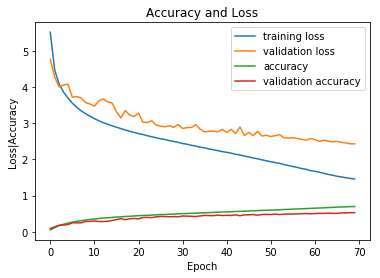

In [32]:
import matplotlib.pyplot as plt
numOfEpoch = 70
fig = plt.figure()
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()
plt.show()